In [1]:
import matplotlib.pyplot as plt, pyvista
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point,Polygon
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random
from shapely.ops import unary_union
from t4gpd.commons.RayCasting3Lib import RayCasting3Lib
from t4gpd.morph.STGrid import STGrid
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess

# Basic Function

In [2]:
def distance3d(point1,point2):
    d = sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2 + (point1.z-point2.z)**2)
    return d

In [3]:
def centroid(self): #rectangle centroid
    coord = self.exterior.coords
    face_p0=np.array(coord[0])
    face_p2=np.array(coord[2])
    face_ce=(face_p0+face_p2)/2
    return Point(face_ce)

In [4]:
def GroundGridIn3d(grid_geo):
    gridin3d = GeomLib.forceZCoordinateToZ0(grid_geo,z0=0)
    return gridin3d

In [5]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [6]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [7]:
def isa(face1,face2):#view factor from 1 to 2
    n1=SurfaceNormal(face1.geometry)
    n2=SurfaceNormal(face2.geometry)
    a2=area3d(face2.geometry)
    vec_R=np.array([face1.CentroidPoint.x-face2.CentroidPoint.x,face1.CentroidPoint.y-face2.CentroidPoint.y,face1.CentroidPoint.z-face2.CentroidPoint.z])
    vf=-a2*np.dot(n1,vec_R)*np.dot(n2,vec_R)/(pi*module(vec_R)**4)
    return vf

In [8]:
#grid surface3d into meshes of size n*m
def grid3d(self,n,m):#n rows, m columns
    coord = self.exterior.coords
    p0=np.array(coord[0])
    p1=np.array(coord[1])
    p2=np.array(coord[2])
    p3=np.array(coord[3])
    vec1 = (p1-p0)/m
    vec2 = (p2-p1)/n
    poly=[]
    cen_p=[]
    sur_d=[]
    for i in range(n):
        for j in range(m):
            p0_t=Point(p0+j*vec1+i*vec2)
            p1_t=Point(p0+(j+1)*vec1+i*vec2)
            p2_t=Point(p0+(j+1)*vec1+(i+1)*vec2)
            p3_t=Point(p0+j*vec1+(i+1)*vec2)
            face_t = Polygon([p0_t,p1_t,p2_t,p3_t,p0_t])
            poly.append(face_t)
            cen_p.append(centroid(face_t))
            sur_d.append(Surface_diameter(face_t))
    self_grid=GeoDataFrame({'geometry': poly},crs='epsg:2154')
    self_grid['CentroidPoint']=cen_p
    self_grid['diameter']=sur_d
    return self_grid

In [9]:
#Subdivide function
def isFiveTimeRuleOk(f1,f2):
    return distance3d(f1.CentroidPoint,f2.CentroidPoint) >= 5*f1.diameter

def Subdivide(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        result = []
        f_grid = grid3d(f1.geometry,2,2)
        for i in range(len(f_grid)):
            if isFiveTimeRuleOk(f_grid.iloc[i],f2):
                result.append(f_grid.iloc[i])
            else:
                result += Subdivide(f_grid.iloc[i],f2)
        return result

In [10]:
#get area from 3d polygon
def area3d(self):
    coord = self.exterior.coords
    d1 = distance3d(Point(coord[0]),Point(coord[1]))
    d2 = distance3d(Point(coord[1]),Point(coord[2]))
    return d1*d2

In [11]:
def Surface_diameter(surface):
    coord = surface.exterior.coords
    d = distance3d(Point(coord[0]),Point(coord[2]))
    return d

# Research Model

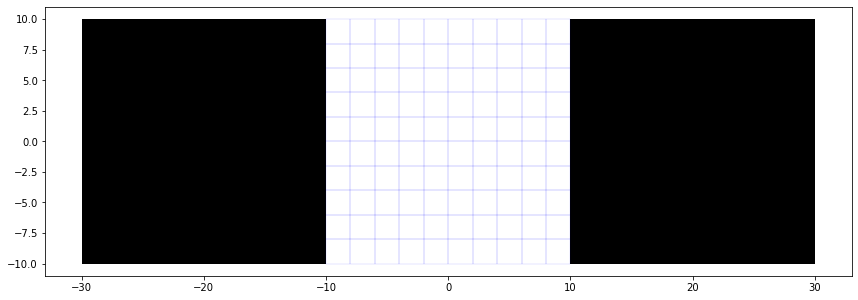

In [12]:
#~ ======================================================================
buildings = GeoDataFrameDemos.regularGridO#get area from 3d polygon
hauteur = [20 for item in range(len(buildings))]
buildings['HAUTEUR'] = hauteur

dx = 2
grid = STGrid(buildings, dx, dy=None, indoor=False, intoPoint=False, encode=False).run()
grid.gid=grid.index

fig, basemap = plt.subplots(figsize=(1.75 * 8.26, 1.2 * 8.26))
buildings.plot(ax=basemap, color='black')
grid.boundary.plot(ax=basemap, color='blue', linewidth=0.1)

plt.show()
plt.close(fig)

# 2.5D to 3D

In [13]:
#transfer buildings and ground grid into 3d coordinates
op = FootprintExtruder(buildings, 'HAUTEUR', forceZCoordToZero=True)
buildingsIn3d = STGeoProcess(op, buildings).run()

grid_geo = [GroundGridIn3d(item) for item in grid.geometry]
GridIn3d = GeoDataFrame.copy(grid)
GridIn3d.geometry=grid_geo

sidewall=[]
gid=[]
fid=[]
for i in range(len(buildings)):
    base_face = GeomLib.forceZCoordinateToZ0(buildings.geometry[i],z0=0)
    roof_face = GeomLib.forceZCoordinateToZ0(buildings.geometry[i],z0=buildings.HAUTEUR[i])
    coordIn3d_base = base_face.exterior.coords
    coordIn3d_roof = roof_face.exterior.coords
    for j in range(4):
        sidewall.append(Polygon([coordIn3d_base[j],coordIn3d_base[j+1],coordIn3d_roof[j+1],coordIn3d_roof[j],coordIn3d_base[j]]))
        fid.append(int(j))
        gid.append(buildings.gid[i])
SidewallsIn3d = GeoDataFrame({'geometry':sidewall},crs='epsg:2154')
SidewallsIn3d['gid']=gid
SidewallsIn3d['fid']=fid

In [14]:
#save centroid points of each surface
GridIn3d['CentroidPoint'] = [centroid(face_g) for face_g in GridIn3d.geometry]
SidewallsIn3d['CentroidPoint'] = [centroid(face_s) for face_s in SidewallsIn3d.geometry]

#get diameter of the surface
SidewallsIn3d['diameter'] = [Surface_diameter(face_s) for face_s in SidewallsIn3d.geometry]
GridIn3d['diameter'] = [Surface_diameter(face_g) for face_g in GridIn3d.geometry]

#area of the surfaces
SidewallsIn3d['area'] = [area3d(face_s) for face_s in SidewallsIn3d.geometry]
GridIn3d['area'] = [area3d(face_g) for face_g in GridIn3d.geometry]

GridIn3d = GridIn3d.drop(columns=['neighbors4','neighbors8','indoor'])
GridIn3d['lable'] = ['ground' for face_g in GridIn3d.geometry]
SidewallsIn3d['lable'] = ['wall' for face_s in SidewallsIn3d.geometry]

GridIn3d['HeatCapacity']= [840 for i in GridIn3d.geometry]
GridIn3d['MassPerUnitArea']= [2243 for i in GridIn3d.geometry]
GridIn3d['Albedo']= [0.1 for i in GridIn3d.geometry]
GridIn3d['Emissivity']= [0.5 for i in GridIn3d.geometry]

SidewallsIn3d['HeatCapacity']= [880 for i in SidewallsIn3d.geometry]
SidewallsIn3d['MassPerUnitArea']= [2400 for i in SidewallsIn3d.geometry]
SidewallsIn3d['Albedo']= [0.6 for i in SidewallsIn3d.geometry]
SidewallsIn3d['Emissivity']= [0.3 for i in SidewallsIn3d.geometry]

GridIn3d['T0']= [3 for i in GridIn3d.geometry]
SidewallsIn3d['T0']= [3 for i in SidewallsIn3d.geometry]

In [15]:
#select one wall as our study surface
testwall0 = GeoDataFrame.copy(SidewallsIn3d.loc[(SidewallsIn3d.gid==0) & (SidewallsIn3d.fid==3)])
testwall0 = testwall0.reset_index(drop=True)
testwall1 = GeoDataFrame.copy(SidewallsIn3d.loc[(SidewallsIn3d.gid==1) & (SidewallsIn3d.fid==1)])
testwall1 = testwall1.reset_index(drop=True)

# View Factor

View factor between sidewall and ground grid

In [16]:
#Create DataFrame to save viewfactor
namelist=[]
for i in range(len(SidewallsIn3d)):
    gid_name = SidewallsIn3d.loc[i,'gid']
    fid_name = SidewallsIn3d.loc[i,'fid']
    namelist.append("Sidewallsgid{gid_name}fid{fid_name}".format(gid_name=gid_name,fid_name=fid_name))
for j in range(len(GridIn3d)):
    gid_name2 = GridIn3d.loc[j,'gid']
    namelist.append("Gridgid{gid_name2}".format(gid_name2=gid_name2))
    
ViewFactorFrame = pd.DataFrame(np.zeros((len(SidewallsIn3d)+len(GridIn3d),len(SidewallsIn3d)+len(GridIn3d))))
ViewFactorFrame.columns = namelist
ViewFactorFrame.index = namelist

In [17]:
#return the visible ground grid geodataframe
def SelectGrid(self,grid,ran):
    ptA = self.CentroidPoint
    bound = ptA.buffer(ran)
    cov_grid = []
    cov_gid = []
    cov_area = []
    cov_cen = []
    for i in range(len(grid)):
        covisible, ray = RayCasting3Lib.areCovisibleIn3D(ptA, grid.CentroidPoint[i], buildings, 'HAUTEUR')
        if covisible and grid.CentroidPoint[i].within(bound):
            cov_grid.append(grid.geometry[i])
            cov_gid.append(grid.gid[i])
            cov_area.append(grid.area[i])
            cov_cen.append(grid.CentroidPoint[i])
    CovisibleGrid = GeoDataFrame({'geometry': cov_grid},crs='epsg:2154')
    CovisibleGrid['CentroidPoint'] = cov_cen
    CovisibleGrid['gid'] = cov_gid
    CovisibleGrid['area'] = cov_area
    return CovisibleGrid

In [18]:
%%time
#view factor between sidewalls and ground
for i in range(len(SidewallsIn3d)):
    face = SidewallsIn3d.iloc[i]
    
    #find Covisible ground surface
    CovisibleGrid = SelectGrid(face,GridIn3d,40)
    
    #calculate view factor
    for j in range(len(CovisibleGrid)):
        face_grid = CovisibleGrid.iloc[j]
        list_sub = Subdivide(face,face_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area']=area
        vf_isa = [abs(isa(tg,face_grid)*tg.area/face.area) for tg in testgeo.iloc]
        ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=face.gid,b=face.fid),'Gridgid{c}'.format(c=face_grid.gid)]=sum(vf_isa)
        ViewFactorFrame.loc['Gridgid{c}'.format(c=face_grid.gid),'Sidewallsgid{a}fid{b}'.format(a=face.gid,b=face.fid)]=sum(vf_isa)*face.area/face_grid.area

CPU times: total: 2min 39s
Wall time: 2min 39s


view factor between sidewalls

In [19]:
#Subdivide function 2
def Subdivide2(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        d = distance3d(f1.CentroidPoint,f2.CentroidPoint)/5
        coord1 = f1.geometry.exterior.coords
        w1 = distance3d(Point(coord1[0]),Point(coord1[1]))
        h1 = distance3d(Point(coord1[1]),Point(coord1[2]))
        
        n1 = int(h1/d)+1
        m1 = int(w1/d)+1
        
        return grid3d(f1.geometry,n1,m1)

In [20]:
#problem: I have to test every point of the surface since maybe some parts of the surface are facing, some are not
def FaceSurface(sensor,surface):
    n1 = SurfaceNormal(surface)
    n2 = sensor.normalvector
    coords = surface.exterior.coords
    point = np.array(sensor.geometry)
    for j in range(1,len(coords)):
        vec = np.array(coords[j])-point
        con1 = vec.dot(n1)#/(module(vec)*module(n2))
        con2 = vec.dot(n2)
        if con2>0 and con1<0:
            return True
        else:
            continue
    return False

In [21]:
%%time
#view factor between sidewalls
d = GeoDataFrame(Subdivide2(testwall0.iloc[0],testwall1.iloc[0]))
c = GeoDataFrame(Subdivide2(testwall1.iloc[0],testwall0.iloc[0]))
vftest = 0
for i in range(len(d)):
    face_0 = d.iloc[i]
    vf2_isa = [isa(face_0,face_1) for face_1 in c.iloc]
    vftest = vftest + sum(vf2_isa)/len(d)

ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=0,b=3),'Sidewallsgid{c}fid{d}'.format(c=1,d=1)]=vftest
ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=1,b=1),'Sidewallsgid{c}fid{d}'.format(c=0,d=3)]=vftest

CPU times: total: 891 ms
Wall time: 894 ms


# Shortwave Radiation

In [22]:
#direct and diffuse irradiance of each sensor(using Perez method)
from t4gpd.energy.Perez import Perez
from pysolar.solar import *
from datetime import *
from t4gpd.commons.AngleLib import AngleLib
from t4gpd.commons.DatetimeLib import DatetimeLib

In [23]:
def SunbeamVector(altitude_angle,azimuth_angle):#get the sunbeam vector depending on the altitude and azimuth angle
    vector_sun_x = sin(azimuth_angle)*cos(altitude_angle)
    vector_sun_y = cos(azimuth_angle)*cos(altitude_angle)
    vector_sun_z = sin(altitude_angle)
    vector_sun = np.array([vector_sun_x,vector_sun_y,vector_sun_z])
    return vector_sun

In [24]:
#create sensors depends on nm
def STEvenPoints(face,n,m): #row=n, column=m
    p = face.exterior.coords
    vec1 = np.array(p[2])-np.array(p[1])
    vec2 = np.array(p[1])-np.array(p[0])
    L1 = vec1/n
    L2 = vec2/m
    s = []
    normal = []
    for i in range(1,n+1):
        for j in range(1,m+1):
            point_1 = np.array(p[0])+L2*(j-1)+L1*(i-1)
            point_2 = np.array(p[0])+L2*j+L1*i
            point_c = Point((point_1+point_2)/2)
            s.append(point_c)
            normal.append(SurfaceNormal(face))
    p_geodata = GeoDataFrame({'geometry':s},crs='epsg:2154')
    p_geodata['NormalVector'] = normal
    return p_geodata

In [25]:
#if it is under sunlit or not
def Sunlit2(sunbeam,point,buildings,normal):
    if np.dot(sunbeam,normal)<0:
        return False
    else:
        p = np.array([point.x,point.y,point.z])
        sun = sunbeam*100+p
        covisible, ray = RayCasting3Lib.areCovisibleIn3D(point, Point(sun), buildings, 'HAUTEUR')
        return covisible

In [26]:
def cosVectorAngle(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return dot_vector

# Longwave Radiation

In [28]:
#rh is the relativve humidity(%),ta is the air temperature
def VaporPressure(ta,rh):
    vp = rh*6.1121*exp((18.678-ta/234.4)*ta/(257.14+ta))
    return vp

In [29]:
#Atmosphere longwave radiation,we set N(degree of cloudiness)=8,all air temperature unite is ℃,rh is the relativve humidity(%),
def AtmoLongRadiation(ta,N,rh):
    p = VaporPressure(ta,rh)
    #ta is the air temperature; N is the degree of cloudiness; p is the vapor pressure(hPa)
    con = 5.67e-8#Stefan-Boltzmann constant
    LR = con*(ta+273.15)**4*(0.82-0.25*10**(-0.0945*p))*(1+0.21*(N/8)**2.5)
    return LR

In [30]:
#get mean sky view factor for surface
def svf(surface,n,m,buildings):
    sensors = STEvenPoints(surface.geometry.iloc[0],n,m)
    op = SkyViewFactor(buildings,nRays=64,maxRayLen=100,elevationFieldname='HAUTEUR',method=2018,background=True)
    sensors = STGeoProcess(op,sensors).run()
    svf = np.mean(sensors.svf)
    return svf

In [31]:
def AbsRadiation(surface,n,m,latitude,longitude,date,buildings,delta,epsilon,ta,N,rh):
    con = 5.67e-8
    sensors = STEvenPoints(surface.geometry.iloc[0],n,m)
    altitude_angle = AngleLib.toRadians(get_altitude(latitude,longitude,date))
    azimuth_angle = AngleLib.toRadians(get_azimuth(latitude,longitude,date))
    sunbeam = SunbeamVector(altitude_angle,azimuth_angle)
    sunhit = [Sunlit2(sunbeam,sensors.geometry[i],buildings,sensors.NormalVector[i]) for i in range(len(sensors))]
    sensors['Sunhit'] = sunhit
    
    days = date.timetuple().tm_yday
    Dir = Perez.directSolarIrradiance(altitude_angle,days,delta,epsilon)
    Dif = Perez.diffuseSolarIrradiance(altitude_angle,days,delta)
    Atm = AtmoLongRadiation(ta,N,rh)
    
    #direct solar radiation
    Dir1=[]
    area_surface = area3d(surface.geometry.iloc[0])
    area_grid = area_surface/(n*m)
    for i in range(len(sensors)):
        if sensors.Sunhit[i]==True:
            Dir1.append(Dir*abs(cosVectorAngle(sunbeam,sensors.NormalVector[i]))*area_grid*surface.Albedo.iloc[0]/area_surface)#depends on size of cells
    DirectSolarRadiation = sum(Dir1)
    
    #diffuse solar radiation and longwave atmosphere radiation
    DiffuseRadiation= (Dif*surface.Albedo.iloc[0]+Atm*(1-surface.Emissivity.iloc[0]))*surface.svf.iloc[0]
    
    #emitting radiation
    e=0.5*surface.Emissivity.iloc[0]*con*(surface.T0.iloc[0]+273.15)**4
    
    Radiation = DiffuseRadiation+DirectSolarRadiation-e
    return Radiation

# Convection

Convection depends on the wind speed. Since we cannot simulate the wind speed under the city canopy, we shall give a constant value.The convection coefficient h is estimated as h = 4*uair + 4. Wind speed is according to the weather data at each time step.

In [32]:
def CovectionCoefficient(uair):
    return 4*uair+4

In [33]:
#air temperature,wind speed,surface temperature
def Convection(ta,uair,ts):
    h = CovectionCoefficient(uair)
    qv = h*(ta-ts)
    return qv

# Final test

In [34]:
#variation of surface temperature
def DeltaT(surface,n,m,allfaces,latitude,longitude,date,buildings,delta,epsilon,ta,N,rh,uair,ViewFactorFrame):
    thickness=0.1
    density = 2076
    h=surface.HeatCapacity.squeeze() # surface.HeatCapacity.squeeze()
    Q_abs = AbsRadiation(surface,n,m,latitude,longitude,date,buildings,delta,epsilon,ta,N,rh)
    Q_v = Convection(ta,uair,surface.T0.squeeze())
    Q_s = SurfaceLongwave(surface,allfaces,ViewFactorFrame)
    delta_t = (Q_abs+Q_v+Q_s)/(thickness*density*h) 
    return delta_t

In [35]:
#longwave radiation emitting from other surfaces and accepted by source surface
def SurfaceLongwave(surface,allfaces,ViewFactorFrame):
    longwave = []
    area_s = area3d(surface.geometry.squeeze())
    if surface.lable.squeeze()=='wall':
        gid = surface.gid.squeeze()*4
        fid = surface.fid.squeeze()
    else:
        gid = surface.gid.squeeze()
        fid = 8
    for i in range(len(allfaces)):
        vf_i = ViewFactorFrame.iloc[i,int(gid+fid)]
        if vf_i==0:
            longwave.append(0)
        else:
            e=0.5*allfaces.Emissivity.iloc[i]*con*(allfaces.T0.iloc[i]+273.15)**4
            longwave.append(e*(1-surface.Emissivity.squeeze())*vf_i*area3d(allfaces.geometry.iloc[i])/area_s)
    return sum(longwave)

In [48]:
#output the surface temperature at set date
def SurfaceTemperature(date,allfaces,latitude,longitude,buildings,delta,epsilon,ta,N,rh,uair,ViewFactorFrame):
    hour = date.hour
    minute = date.minute
    num = int(((hour-8)*60+minute)/30) #we set 8 am sunrise, num is number of loop
    rem = ((hour-8)*60+minute)%30 #rem is the remainder
    allfaces['T0']= [3 for i in allfaces.geometry] #initial value
    date = date.replace(hour=8, minute=0)
    x = 0
    while x<num:
        deltt = []
        T = []
        for i in range(len(allfaces)):
            surface = GeoDataFrame.copy(allfaces.loc[(allfaces.index==i)])
            if surface.lable.squeeze()=='ground':
                n = 1
                m = 1
            else:
                n = 10
                m = 10
            dt = DeltaT(surface,n,m,allfaces,latitude,longitude,date,buildings,delta,epsilon,ta,N,rh,uair,ViewFactorFrame)
            deltt.append(dt)
            T.append(surface.T0.squeeze()+dt*1800)
        date = date+timedelta(minutes = 30)
        allfaces.T0 = T
        x = x + 1
    dt_min = [item*rem for item in deltt]
    allfaces.T0 = [t+dt for t,dt in zip(T,dt_min)]
    return allfaces

In [65]:
%%time
#First we set our initial value
t_va = 1 / 3600 #temperature variation threhold
ta = 12 #air temperature
uair = 6 #wind speed
rh = 0.4 #relative humidity
con = 5.67e-8 #Stefan-Boltzmann constant
N = 8 #cloudiness
delta = 0.12 #sky's brightness (Perez et al.,1993)
epsilon = 6.3 #sky's clearness (Perez et al.,1993)
latitude = 47.16
longitude = -1.60

allfaces = pd.concat([SidewallsIn3d,GridIn3d])
allfaces['T0'] = [3 for i in allfaces.geometry]
allfaces = allfaces.reset_index(drop=True)
skyviewfactor = []
for i in range(len(allfaces)):
    surface = GeoDataFrame.copy(allfaces.loc[(allfaces.index==i)])
    if surface.lable.squeeze()=='ground':
        n = 1
        m = 1
    else:
        n = 10
        m = 10
    skyviewfactor.append(svf(surface,n,m,buildings))
allfaces['svf'] = skyviewfactor

SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0

In [70]:
%%time

date = datetime(2020,6,21,10,30,tzinfo=timezone.utc)
allfaces = SurfaceTemperature(date,allfaces,latitude,longitude,buildings,delta,epsilon,ta,N,rh,uair,ViewFactorFrame)

CPU times: total: 8.5 s
Wall time: 8.5 s


# Result

In [71]:
scene1 = ToUnstructuredGrid([allfaces],'T0').run()
scene1.plot(scalars='T0',cmap='gist_earth',show_edges=False,
	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Reflected radiation

In [85]:
def SymmetyVector(v1,n1):
    v2 = 2*np.dot(v1,n1)*n1/module(n1)**2-v1
    return v2